# 7 WorkFlow

### 7.1 Objetivo

Presentar un workflow/pipeline completo al que los estudiantes deberán enriquecer

#### 7.2  Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Type -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

Para correr la siguiente celda es fundamental en Arranque en Frio haber copiado el archivo kaggle.json al Google Drive, en la carpeta indicada en el instructivo

<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   "instalar" el archivo kaggle.json desde el Google Drive a la virtual machine para que pueda ser utilizado por la libreria  kaggle de Python
*   Bajar el  **dataset_pequeno**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab
*   Bajar el **dataset_historico** al Google Drive y tambien al disco local de la virtual machine que esta corriendo Google Colab



*  Si usted eligió modalidad *Gerencial* entonces NO debe modificar nada, su liderazgo logró que otras trabajaron por usted
*  Si usted eligió modalidad de *Analista Junior*, entonces donde dice archivo="gerencial_competencia_2025.csv.gz"  lo debe cambiar por  archivo="analistajr_competencia_2025.csv.gz"
*  Si usted eligió modalidad *Analista Senior*,  ya se las ingenierá SIN preguntar !

## 7.3  Workflow

## Inicializacion

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

limpio el ambiente de R

In [1]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "Sat Jul 05 02:08:45 2025"

In [2]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,657046,35.1,1439334,76.9,1432358,76.5
Vcells,1225339,9.4,8388608,64.0,1924957,14.7


In [3]:
require("data.table")

if( !require("R.utils")) install.packages("R.utils")
require("R.utils")

Loading required package: data.table

Loading required package: R.utils

Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings




In [7]:
PARAM <- list()
PARAM$semilla_primigenia <- 234113

PARAM$experimento <- "Colaborativo-6"
PARAM$dataset <- "analistasr_competencia_2025.csv.gz"

In [8]:
# carpeta de trabajo

setwd("/content/buckets/b1/exp")
experimento_folder <- paste0("WF", PARAM$experimento)
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

In [9]:
# Load necessary libraries
library(data.table)
library(ggplot2)
library(stringr)

In [10]:
base_path <- "/content/buckets/b1/exp"

In [11]:
# Listar carpetas que contienen 'Colaborativo' (o cualquier otro filtro)
carpetas <- list.dirs(path = base_path, recursive = FALSE, full.names = TRUE)
carpetas <- carpetas[grepl("Colaborativo", carpetas)]

In [12]:
carpetas

[1] "/content/buckets/b1/exp/WFColaborativo-1"
[2] "/content/buckets/b1/exp/WFColaborativo-2"
[3] "/content/buckets/b1/exp/WFColaborativo-3"
[4] "/content/buckets/b1/exp/WFColaborativo-5"
[5] "/content/buckets/b1/exp/WFColaborativo-6"

In [14]:
cortes <- 4*seq(800, 1300, by = 50)


In [15]:
resultados <- list()

In [21]:
for (carpeta in carpetas) {
  archivos <- list.files(path = carpeta, pattern = "^prediccion_\\d+\\.txt$", full.names = TRUE)

  for (archivo in archivos) {
    pred <- fread(archivo)
    pred <- pred[order(-prob)]

    pred[, Ganancia := ifelse(clase_ternaria == "BAJA+2", 117000, -3000)]
    pred[, Ganancia_acum := cumsum(Ganancia)]

    cortes <- 6*seq(200, 6000, 50)
    pred_cortes <- pred[cortes, .(envios = cortes, Ganancia_acum)]

    pred_cortes[, semilla := str_extract(basename(archivo), "\\d+")]
    pred_cortes[, exp := basename(carpeta)]

    resultados[[length(resultados) + 1]] <- pred_cortes
  }
}

# Combinar resultados
curvas <- rbindlist(resultados)

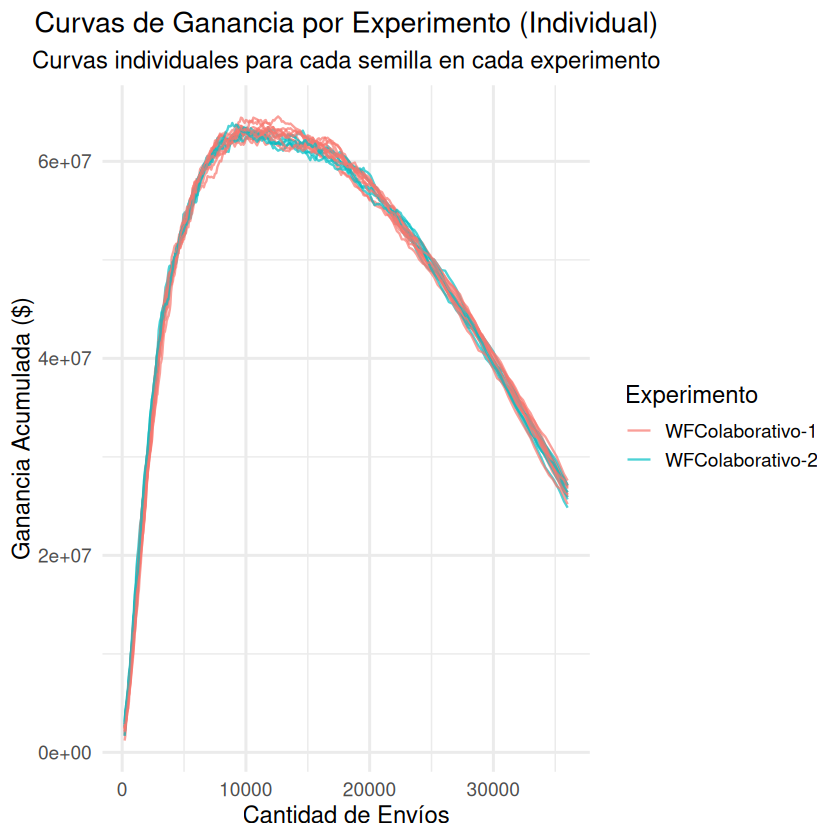

In [22]:
# Gráfico de todas las curvas individuales con líneas más delgadas
ggplot(curvas, aes(x = envios, y = Ganancia_acum, color = exp, group = interaction(exp, semilla))) +
  geom_line(linewidth = 0.5, alpha = 0.7) + # Reduced linewidth to 0.5
  labs(
    title = "Curvas de Ganancia por Experimento (Individual)",
    subtitle = "Curvas individuales para cada semilla en cada experimento",
    x = "Cantidad de Envíos",
    y = "Ganancia Acumulada ($)",
    color = "Experimento"
  ) +
  theme_minimal(base_size = 14) +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5))

p <- ggplot(curvas, aes(x = envios, y = Ganancia_acum, color = exp, group = interaction(exp, semilla))) +
  geom_line(linewidth = 0.5, alpha = 0.7) + # Reduced linewidth
  labs(
    title = "Curvas de Ganancia por Experimento (Individual)",
    subtitle = "Curvas individuales para cada semilla en cada experimento",
    x = "Cantidad de Envíos",
    y = "Ganancia Acumulada ($)",
    color = "Experimento"
  ) +
  theme_minimal(base_size = 14) +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5))



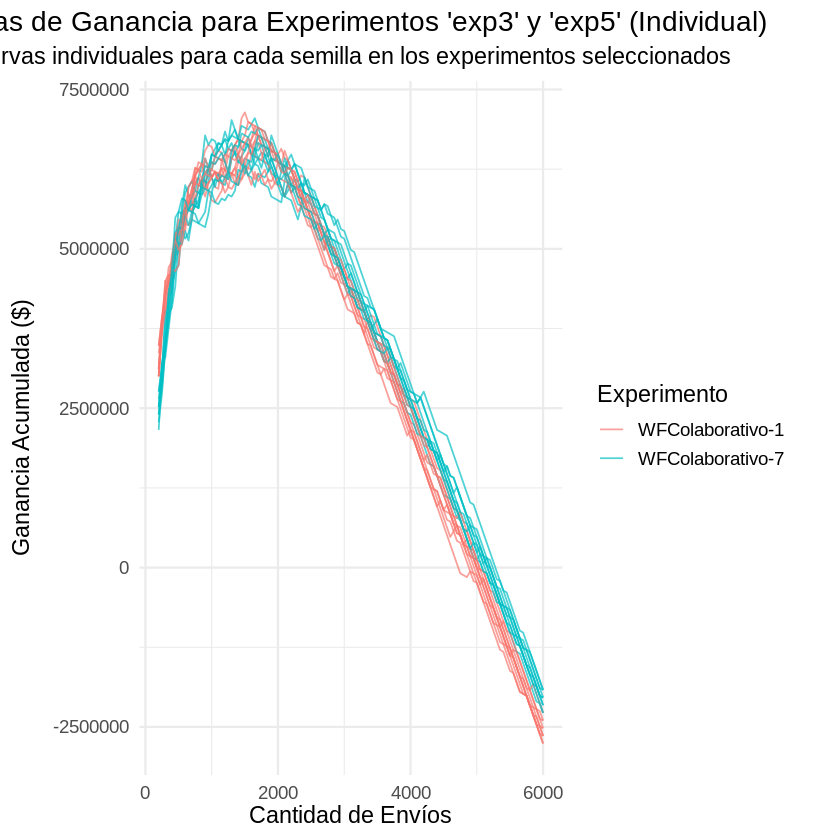

In [31]:
# Filtrar las curvas para incluir solo los experimentos 'exp3' y 'exp5'
curvas_filtradas <- curvas[exp %in% c("WFColaborativo-1", "WFColaborativo-7")]


ggplot(curvas_filtradas, aes(x = envios, y = Ganancia_acum, color = exp, group = interaction(exp, semilla))) +
  geom_line(linewidth = 0.5, alpha = 0.7) +
  labs(
    title = "Curvas de Ganancia para Experimentos 'exp3' y 'exp5' (Individual)",
    subtitle = "Curvas individuales para cada semilla en los experimentos seleccionados",
    x = "Cantidad de Envíos",
    y = "Ganancia Acumulada ($)",
    color = "Experimento"
  ) +
  theme_minimal(base_size = 14) +
  theme(plot.title = element_text(hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5))

In [23]:
curvas_promedio <- curvas[, .(Ganancia_acum_mean = mean(Ganancia_acum)), by = .(exp, envios)]


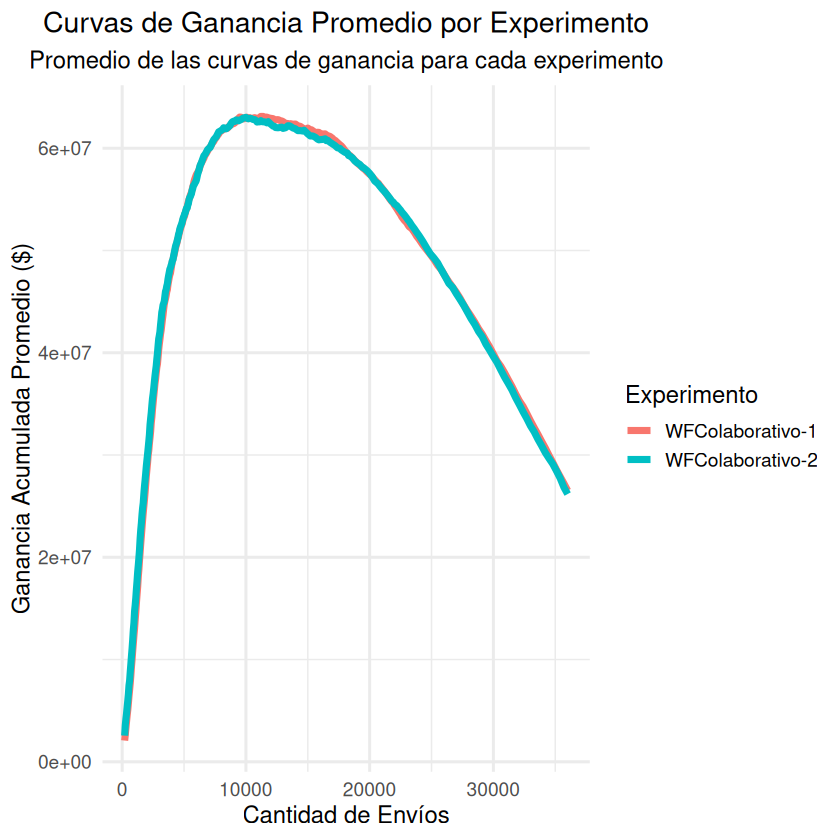

In [24]:
ggplot(curvas_promedio, aes(x = envios, y = Ganancia_acum_mean, color = exp)) +
  geom_line(linewidth = 1.5) + # Slightly thicker line for average curves
  labs(
    title = "Curvas de Ganancia Promedio por Experimento",
    subtitle = "Promedio de las curvas de ganancia para cada experimento",
    x = "Cantidad de Envíos",
    y = "Ganancia Acumulada Promedio ($)",
    color = "Experimento"
  ) +
  theme_minimal(base_size = 14) +
  theme(plot.title = element_text(hjust = 0.5), # Center plot title
        plot.subtitle = element_text(hjust = 0.5)) # Center plot subtitle


Wilcoxon

In [25]:
comparison_envios_cutoff <- 2000 # You can change this value

In [26]:
compare_experiments_wilcoxon <- function(exp_name1, exp_name2, data_dt, cutoff_envios) {

  # Extract paired data for the two experiments at the specified cutoff
  # We need to ensure the data is joined/merged by 'semilla' to maintain pairing.

  # Filter data for the relevant experiments and cutoff
  filtered_data <- data_dt[exp %in% c(exp_name1, exp_name2) & envios == cutoff_envios]

  # Pivot wider to get paired vectors for each seed
  # Using dcast to reshape the data.
  paired_gains <- dcast(filtered_data, semilla ~ exp, value.var = "Ganancia_acum")

  # Check if both columns exist and have data
  if (!exp_name1 %in% names(paired_gains) || !exp_name2 %in% names(paired_gains)) {
    warning(paste0("One or both experiment names (", exp_name1, ", ", exp_name2, ") not found at cutoff ", cutoff_envios, ". Skipping test."))
    return(list(p_value = NA, significant = NA))
  }

  vec1 <- paired_gains[[exp_name1]]
  vec2 <- paired_gains[[exp_name2]]

  # Ensure lengths are equal and no NAs, critical for paired test
  if (length(vec1) != length(vec2) || any(is.na(vec1)) || any(is.na(vec2))) {
    warning(paste0("Mismatch in length or NA values for ", exp_name1, " vs ", exp_name2, ". Cannot perform paired Wilcoxon test. Skipping."))
    return(list(p_value = NA, significant = NA))
  }

  # Perform the paired Wilcoxon test
  wilcox_result <- wilcox.test(vec1, vec2, paired = TRUE)

  # Return the p-value and a boolean indicating significance
  return(list(
    p_value = wilcox_result$p.value,
    # You might want to adjust significance threshold later for multiple comparisons
    # For now, let's just return the raw p-value
    significant = wilcox_result$p.value < 0.05 # Initial significance check (will be adjusted)
  ))
}

In [27]:
all_experiments <- unique(curvas$exp)
all_experiments <- sort(all_experiments) # Sort for consistent pairing order

In [28]:
results_list <- list()
raw_p_values <- c()
pair_names <- c()

In [29]:
n_experiments <- length(all_experiments)
for (i in 1:(n_experiments - 1)) {
  for (j in (i + 1):n_experiments) {
    exp1 <- all_experiments[i]
    exp2 <- all_experiments[j]

    cat(paste0("Comparing ", exp1, " vs ", exp2, " at envios = ", comparison_envios_cutoff, "...\n"))

    # Call the modular function
    test_output <- compare_experiments_wilcoxon(exp1, exp2, curvas, comparison_envios_cutoff)

    # Store results
    pair_name <- paste0(exp1, " vs ", exp2)
    results_list[[pair_name]] <- test_output

    if (!is.na(test_output$p_value)) {
      raw_p_values <- c(raw_p_values, test_output$p_value)
      pair_names <- c(pair_names, pair_name)
    }
  }
}


Comparing WFColaborativo-1 vs WFColaborativo-2 at envios = 2000...


Warning message in dcast.data.table(filtered_data, semilla ~ exp, value.var = "Ganancia_acum"):
“'fun.aggregate' is NULL, but found duplicate row/column combinations, so defaulting to length(). That is, the variables [semilla, exp] used in 'formula' do not uniquely identify rows in the input 'data'. In such cases, 'fun.aggregate' is used to derive a single representative value for each combination in the output data.table, for example by summing or averaging (fun.aggregate=sum or fun.aggregate=mean, respectively). Check the resulting table for values larger than 1 to see which combinations were not unique. See ?dcast.data.table for more details.”
Warning message in wilcox.test.default(vec1, vec2, paired = TRUE):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(vec1, vec2, paired = TRUE):
“cannot compute exact p-value with zeroes”


In [30]:
adjusted_p_values <- p.adjust(raw_p_values, method = "holm")

# Combine results into a data.table for easy viewing
final_results_dt <- data.table(
  Pair = pair_names,
  Raw_P_Value = raw_p_values,
  Adjusted_P_Value_Holm = adjusted_p_values,
  Significance_Holm = adjusted_p_values < 0.05 # Using 0.05 as alpha for significance
)

In [31]:
print("\n--- Summary of Pairwise Wilcoxon Tests (Paired, Holm-adjusted) ---")
print(final_results_dt)

cat(paste0("\nSignificance Level (alpha) used for Adjusted P-value: 0.05\n"))
cat("If 'Significance_Holm' is TRUE, there is a statistically significant difference in median gains.\n")


[1] "\n--- Summary of Pairwise Wilcoxon Tests (Paired, Holm-adjusted) ---"
                                   Pair Raw_P_Value Adjusted_P_Value_Holm
                                 <char>       <num>                 <num>
1: WFColaborativo-1 vs WFColaborativo-2  0.07186064            0.07186064
   Significance_Holm
              <lgcl>
1:             FALSE

Significance Level (alpha) used for Adjusted P-value: 0.05
If 'Significance_Holm' is TRUE, there is a statistically significant difference in median gains.
